## Initial steps to set up MATLAB Jupyter Notebook

This must be done to ensure MATLAB operates as desired:
1. Follow these steps: https://am111.readthedocs.io/en/latest/jmatlab_install.html
2. (Download CoastSnap) - maybe not necessary actually!
3. Download this file(that this notebook is in), it contains the required demonstration variables.
4. Add this file to the MATLAB path.
5. Alter the the two addpath functions in the code cell below to match the paths on your own computer

## Map Shoreline

The following steps analyse the process used in CoastSnap to map the shoreline on the image.
The overall process is controlled from the function file CSPGmapShoreline.m.
Below are the main steps which are performed.

### 1. Get data from the plan image (georectified) and check if the shoreline has already been mapped.
### 2. Load transect data from the Shorelines file.
### 3. Call mapShorelineCCD.m to determine the shoreline location:

> #### 3.1 Extract pixel RGB (red, green, blue) values for points along each transect:

First load the file with the necessary variables for running the folling demonstrations:

In [1]:
addpath('/Users/nickheaney/Desktop/CoastSnap/Code/GUI');
addpath('/Users/nickheaney/Desktop/CoastSnap-Jupyter-MATLAB')
load('MapShoreline.mat');

***improfile*** identifies the rgb pixel intensities. The function inputs are:
- xgrid : x coordinate system (within image limits)
- ygrid : y coordinate system (within image limits)
- Iplan : (plan) input image
- transects.x : x-coordinates of the transect start and end points
- transects.y : y-coordinates of the transect start and end points


time =

    3.3821



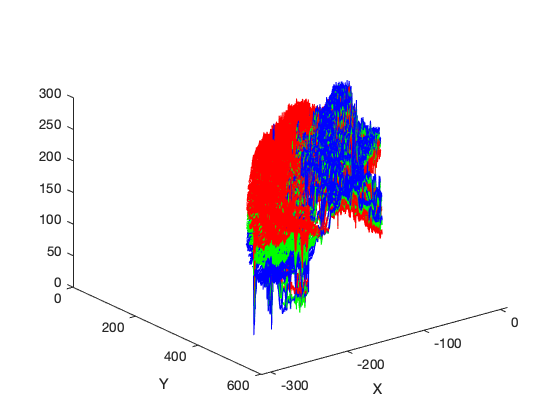

In [2]:
%plot native
tic
P = improfile(xgrid,ygrid,Iplan,transects.x,transects.y);
improfile(xgrid,ygrid,Iplan,transects.x,transects.y)
time = toc

In the above cell, move '%plot native' to below '%plot inline' this will plot the 3D graph in a separate window, allowing you do rotate it and get a better understanding of what it represents. For example, view the graph from above or perpendicular to a transect:
<table><tr><td><img src='improfileAbove.png'></td><td><img src='improfilePerp.png'></td></tr></table>

> #### 3.2 Create a probability density estimate for the range of red minus blue values of the pixels:

The RGB pixel intensity data are now represented by the variable **P**. **P** is an n $*$ 1 $*$ 3 array (where n is the number of pixels sampled along the transects in the previous step). The final dimension of the array is 3 because there are values corresponding to each of the 3 colours: red; green; and blue.

CoastSnap only uses the red and blue colour values. It subtracts the red intensity from the blue intensity (RmB). For the pixels in the variable P, their RmB values are represented by:

In [5]:
P(:,:,1)-P(:,:,3);

These RmB values are used as the input for the next function to be called, ***ksdensity***. This finction creates a probability density describing the likelyhood of each RmB value from in the pixels provided:

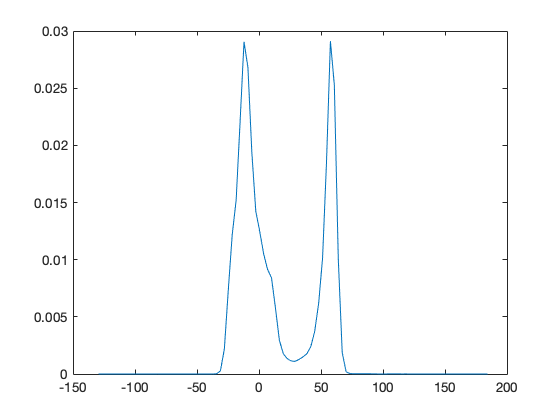

In [3]:
[pdf_values,pdf_locs] = ksdensity(P(:,:,1)-P(:,:,3));
ksdensity(P(:,:,1)-P(:,:,3))

> #### 3.3 Determine the threshold RmB value (the value for the pixels along the shoreline):

The RmB probability density is now used to determine the threshold value representing the shoreline.

First the threshold weightings (which can be adapted to the each individual beach) are defined. These weightings are used to determine the location of the optimum point (RmB value) between the two peaks of the probability density. When downloading CoastSnap the weightings are set at [ 1/3  2/3 ]. That is, the threshold, **RmB<sub>opt</sub> = 1/3 RmB<sub>wet</sub> + 2/3 RmB<sub>dry</sub>**. These are the default threshold weightings because they are the most suitable for South-East Australia. They can be altered regions where sand and ocean colours are different to those in Australia.

In [4]:
thresh_weightings = [1/3 2/3];

To perform the calculation, **RmB<sub>wet</sub>** and **RmB<sub>dry</sub>** must be identified. This requires the RmB values to be classified as wet or dry. This is done by the Otsu method, performed using the ***multithresh*** function.

In [5]:
thresh_otsu = multithresh(P(:,:,1)-P(:,:,3))


thresh_otsu =

   23.4235



The value representing **RmB<sub>wet</sub>** is the peak on the probability density plot corresponding to the lower RmB value (the left peak). This is due to the high blue intensity and low red intensity of these pixels. This peak value is now found:

In [6]:
I1 = find(pdf_locs<thresh_otsu);
[~,J1] = max(pdf_values(I1));

Conversely, the value representing **RmB<sub>dry</sub>** is the peak on the probability density plot corresponding to the higher RmB value (the left peak). Here there is a low blue intensity and a high red intensity of the pixels. This peak value is now found:

In [7]:
I2 = find(pdf_locs>thresh_otsu);
[~,J2] = max(pdf_values(I2));

Now the threshold value, **RmB<sub>opt</sub>** is found:

In [8]:
RmBwet = pdf_locs(I1(J1));
RmBdry = pdf_locs(I2(J2));
thresh_otsu;

thresh = thresh_weightings(1)*RmBwet + thresh_weightings(2)*RmBdry


thresh =

   34.3645



The above steps are represented in the plot generated by the code below which is carried out by the **if plotoption == 1** statement.

In [15]:
%plot_native
plot(pdf_locs,pdf_values,'DisplayName','probability')
hold on
plot(pdf_locs([I1(J1) I2(J2)]),pdf_values([I1(J1) I2(J2)]),'ro','DisplayName','RmBwet(left) RmBdry(right)')
YL = ylim;
plot([thresh thresh], YL,'r:','linewidth',2,'DisplayName','thresh')
plot([thresh_otsu thresh_otsu], YL,'g:','linewidth',2,'DisplayName','thresh otsu')
xlabel(xlabel_type,'fontsize',10)
ylabel('Probability','fontsize',10)
title('Variables represented on the the probability distribution')

legend

#### Key:

| Variable: | Represented by: |
| --- | --- |
| Otsu threshold | Red dotted line |
| RmB<sub>wet</sub> | Red circle on left |
| RmB<sub>dry</sub> | Red circle on right |
| RmB<sub>opt</sub> | Green dotted line |

> #### 3.4 Extract the contours at the threshold value (the same value as the shoreline):

Firstly the RmB values for all of the pixels within the image are found (in the previous steps only values along the tranects were taken). The two images below make what is happening clearer:

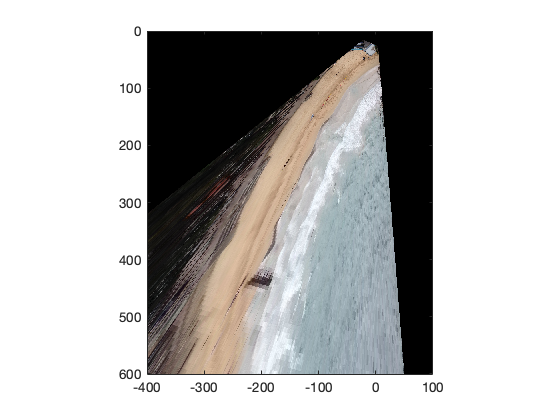

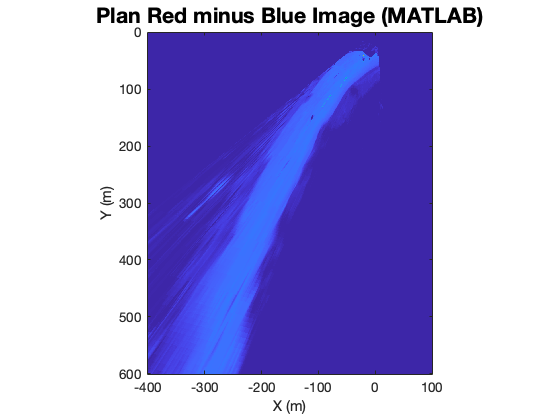

In [9]:
%plot native
RminusBdouble = double(Iplan(:,:,1))- double(Iplan(:,:,3));
image(xgrid,ygrid,Iplan)
axis equal
axis tight
figure
image(xgrid,ygrid,RminusBdouble)
axis equal
axis tight
title('Plan Red minus Blue Image (MATLAB)','FontSize',16)
xlabel('X (m)')
ylabel('Y (m)')

The region of interest is defined next by using the coordinates of the transect start and end points. The plot below illustrates the region being defined:

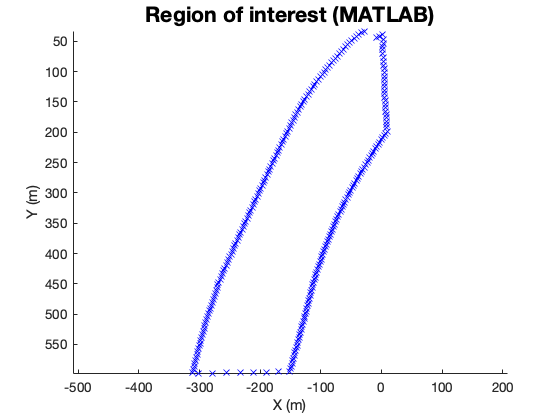

In [10]:
ROIx = [transects.x(1,:) fliplr(transects.x(2,:))];
ROIy = [transects.y(1,:) fliplr(transects.y(2,:))];
scatter(ROIx, ROIy, 'bx')
axis ij
title('Region of interest (MATLAB)','FontSize',16)
xlabel('X (m)')
ylabel('Y (m)')
axis equal

The function ***inpoly*** is used to fully define the polygon bounded by these points. The region outside of the region of interest is then masked. <br> **Note: *inpoly*** (funtion included in the CoastSnap package) is not the same as ***inpolygon*** (built in MATLAB function).

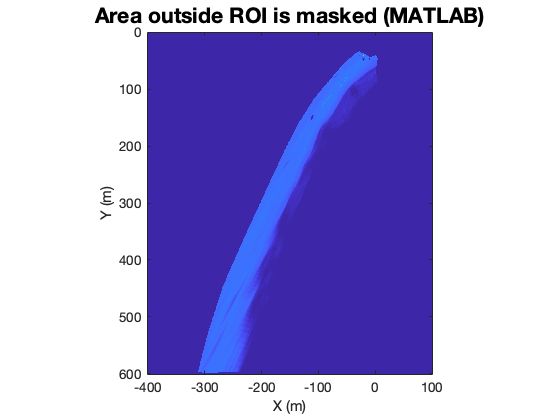

In [11]:
Imask = ~inpoly([X(:) Y(:)],[ROIx',ROIy']);
RminusBdouble(Imask) = NaN;
image(xgrid,ygrid,RminusBdouble)
title('Area outside ROI is masked (MATLAB)','FontSize',16)
xlabel('X (m)')
ylabel('Y (m)')
axis equal
axis tight

**Note**: if ***inpoly*** not working above, make sure that the correct path to the CoastSnap Code folder has been added to the MATLAB path.

The function ***contours*** is then called with the region of interest and the threshold as the inputs (X and Y and meshgrids defined by xgrid and ygrid at the top of mapShorelineCCD.m). This locates the shoreline. The images generated demontrate how this works. <br> **Note:** The images have been generated using ***contour*** not ***contours***. These seem to give the same output but they are not the same function.

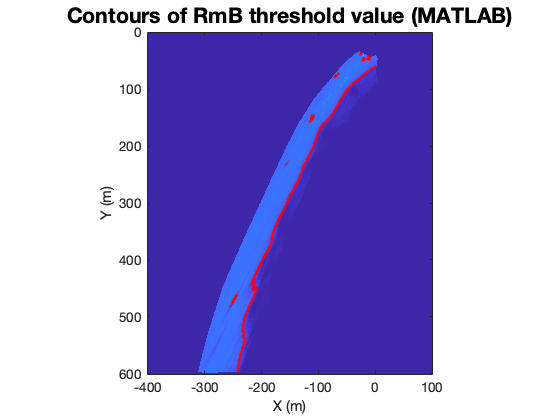

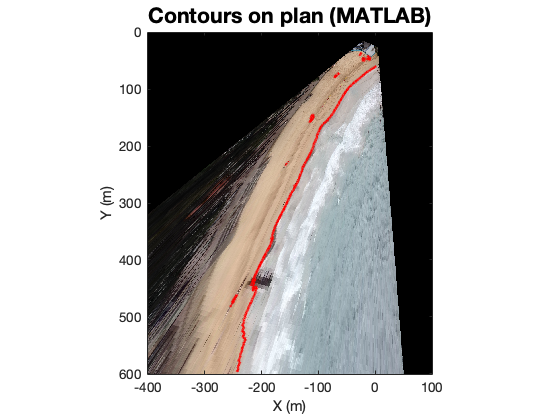

In [12]:
c = contours(X,Y,RminusBdouble,[thresh thresh]);
image(xgrid,ygrid,RminusBdouble)
hold on
contour(X,Y,RminusBdouble,[thresh thresh],'r','linewidth',2)
title('Contours of RmB threshold value (MATLAB)','FontSize',16)
xlabel('X (m)')
ylabel('Y (m)')
axis equal
axis tight
figure
image(xgrid,ygrid,Iplan)
hold on
contour(X,Y,RminusBdouble,[thresh thresh],'r','linewidth',2)
title('Contours on plan (MATLAB)','FontSize',16)
xlabel('X (m)')
ylabel('Y (m)')
axis equal
axis tight

It can be seen from the plot above that several contours for the threshold value exist. Therefore the conour represnting the shoreline needs to be determined. 

>#### 3.5 Determine the contour representing the shoreline:

It is assumed that the contour resprensting the shoreline is the longest contour.<br>The arrangement of the ***contonur/countours*** output is represented below: <img src = 'ContourOutput.png' style = 'width:600px;height:240px'>

The contour value ('Level') and the number of vertices for that value are represented in the first column. Thereafter, the x and y coordinates of the vertices are provided. The value of the next contour and its number of vertices is then provided, followed by vertex coordinates and so on...

The **c** has been defined to only contain contours of the threshold 'level'. When the threshold 'level' is restated  in the **c** matrix, this represents the start of a separate contour. Therefore the number of columns after the threshold value is stated, until the next threshold value, indicates the size of the contour (number of vertices).
<br>**Note**: this method can only be used due to the single threshold 'level' existing in **c**. If other levels existed, the number of vertices indicated below the 'level' in the matrix (see diagram above) would have to be used to identify the contour size.

The matrix locations of elements representing the threshold 'level' and thus the start of a contour are found:

In [13]:
II = find(c(1,:)==thresh);

Below is an image of the current code for ***mapShorelineCCD.m*** <img src = 'contourIfLoop.png' style = 'width:600px;height:290px;float:left'/>

Essentially, if there is more than 1 contour, the largest contour is found using the else loop, with the ***diff( )*** 
function being used as to determine each contour's length. However, there are some problems with the else 
statement. These have been corrected below:

In [14]:
if II==1 %If only one line
    startI = 2;
    endI = size(c,2);
else
    D = diff(II);
    D = D - 1;
    D = [D (size(c,2) - II(end))];
    [~,J] = max(D); %Select contour that is the longest continuous contour
    if J == 1
        startI = 2;
    else
        startI = 1+J+sum(D(1:J-1));
    end
    endI = startI+D(J)-1;
end
xyz.x = c(1,startI:endI)';
xyz.y = c(2,startI:endI)';
points = [xyz.x xyz.y];

In [18]:
%plot native
image(xgrid,ygrid,Iplan)
hold on
plot(xyz.x,xyz.y,'r-','linewidth',2)
title('Shoreline (MATLAB)','FontSize',16)
xlabel('X (m)')
ylabel('Y (m)')
axis equal
axis tight

In [21]:
flipud([xyz.x xyz.y])


ans =

    1.5000   59.7726
    1.1589   60.0000
    1.0000   60.1589
    0.7726   60.5000
    0.5000   60.5584
         0   60.9544
   -0.1823   61.0000
   -0.5000   61.0794
   -0.6589   61.0000
   -1.0000   60.8635
   -1.2274   61.0000
   -1.0975   61.5000
   -1.5000   61.9025
   -1.7274   62.0000
   -2.0000   62.0743
   -2.3602   62.5000
   -2.5000   62.6136
   -3.0000   62.8635
   -3.5000   62.9772
   -4.0000   62.9242
   -4.2274   63.0000
   -4.5000   63.1635
   -4.7403   63.5000
   -5.0000   63.8635
   -5.5000   63.8030
   -5.6970   64.0000
   -6.0000   64.2597
   -6.5000   64.4089
   -6.5911   64.5000
   -7.0000   64.9089
   -7.0911   65.0000
   -7.5000   65.0909
   -7.8348   65.5000
   -8.0000   65.7020
   -8.4470   66.0000
   -8.5000   66.0318
   -9.0000   66.2044
   -9.2956   66.5000
   -9.5000   66.6363
  -10.0000   66.7196
  -10.4206   67.0000
  -10.5000   67.0397
  -11.0000   67.4242
  -11.3411   67.5000
  -11.5000   67.6059
  -11.7956   68.0000
  -12.0000   68.2726
  -12

 -100.0000  175.2726
 -100.0975  175.5000
 -100.1970  176.0000
 -100.4455  176.5000
 -100.5000  176.7726
 -100.5853  177.0000
 -100.8602  177.5000
 -100.9455  178.0000
 -101.0000  178.0681
 -101.3702  178.5000
 -101.5000  178.9544
 -101.5260  179.0000
 -101.7235  179.5000
 -101.8348  180.0000
 -102.0000  180.2020
 -102.1916  180.5000
 -102.3365  181.0000
 -102.5000  181.2726
 -102.5682  181.5000
 -102.6365  182.0000
 -102.9470  182.5000
 -102.9371  183.0000
 -103.0000  183.2726
 -103.0975  183.5000
 -103.3637  184.0000
 -103.0000  184.2182
 -102.8343  184.5000
 -102.8931  185.0000
 -103.0000  185.1398
 -103.3122  185.5000
 -103.2253  186.0000
 -103.5000  186.3949
 -103.6051  186.5000
 -103.7301  187.0000
 -104.0000  187.2699
 -104.1841  187.5000
 -104.2728  188.0000
 -104.5000  188.3925
 -104.5788  188.5000
 -104.7301  189.0000
 -104.9711  189.5000
 -105.0000  189.5794
 -105.2403  190.0000
 -105.5000  190.3635
 -105.5487  190.5000
 -105.5758  191.0000
 -105.7438  191.5000
 -105.8435  1

 -157.5455  304.5000
 -157.8348  305.0000
 -158.0000  305.3635
 -158.0455  305.5000
 -158.3348  306.0000
 -158.5000  306.3635
 -158.5682  306.5000
 -158.8348  307.0000
 -159.0000  307.3635
 -159.0569  307.5000
 -159.2182  308.0000
 -159.5000  308.4696
 -159.5166  308.5000
 -159.7182  309.0000
 -160.0000  309.4696
 -160.0166  309.5000
 -160.2833  310.0000
 -160.5000  310.4696
 -160.5166  310.5000
 -160.7833  311.0000
 -161.0000  311.4696
 -161.0203  311.5000
 -161.2833  312.0000
 -161.5000  312.4696
 -161.5203  312.5000
 -161.7833  313.0000
 -162.0000  313.3522
 -162.1075  313.5000
 -162.3348  314.0000
 -162.5000  314.2597
 -162.6682  314.5000
 -162.8182  315.0000
 -163.0000  315.2597
 -163.1682  315.5000
 -163.5000  315.9740
 -163.5140  316.0000
 -163.6682  316.5000
 -164.0000  316.9740
 -164.0140  317.0000
 -164.1682  317.5000
 -164.5000  317.9740
 -164.5140  318.0000
 -164.7403  318.5000
 -165.0000  318.9544
 -165.0140  319.0000
 -165.2403  319.5000
 -165.5000  319.9544
 -165.5140  3

 -208.3832  421.0000
 -208.5000  421.2726
 -208.7274  421.5000
 -208.8832  422.0000
 -209.0000  422.2726
 -209.2274  422.5000
 -209.3832  423.0000
 -209.5000  423.2726
 -209.7274  423.5000
 -209.8832  424.0000
 -210.0000  424.2726
 -210.2274  424.5000
 -210.3832  425.0000
 -210.5000  425.2726
 -210.7274  425.5000
 -210.8832  426.0000
 -210.8832  426.5000
 -211.0000  426.7726
 -211.1137  427.0000
 -211.3832  427.5000
 -211.5000  427.7726
 -211.6137  428.0000
 -211.8832  428.5000
 -212.0000  428.7726
 -212.1137  429.0000
 -212.3832  429.5000
 -212.5000  429.7726
 -212.6137  430.0000
 -212.7274  430.5000
 -213.0000  430.7726
 -213.1137  431.0000
 -213.2274  431.5000
 -213.5000  431.7726
 -213.6137  432.0000
 -213.5000  432.2274
 -213.2956  432.5000
 -213.5000  432.9089
 -213.5911  433.0000
 -213.7956  433.5000
 -214.0000  433.9089
 -214.0911  434.0000
 -214.2956  434.5000
 -214.5000  434.9089
 -214.5365  435.0000
 -214.7956  435.5000
 -215.0000  435.9089
 -215.0365  436.0000
 -215.2956  4

 -229.5000  527.4682
 -229.3411  527.5000
 -229.5000  527.6589
 -229.8411  528.0000
 -229.8411  528.5000
 -229.8411  529.0000
 -230.0000  529.1589
 -230.3411  529.5000
 -230.3411  530.0000
 -230.5000  530.1589
 -230.8411  530.5000
 -230.8411  531.0000
 -231.0000  531.1589
 -231.3411  531.5000
 -231.3411  532.0000
 -231.5000  532.1589
 -231.8411  532.5000
 -231.8411  533.0000
 -231.8411  533.5000
 -232.0000  533.6589
 -232.3411  534.0000
 -232.3411  534.5000
 -232.5000  534.6589
 -232.8411  535.0000
 -232.8411  535.5000
 -233.0000  535.6589
 -233.3411  536.0000
 -233.0000  536.0758
 -232.5758  536.5000
 -232.5000  536.5758
 -232.0000  536.5758
 -231.5000  536.5758
 -231.0000  536.6478
 -230.6869  537.0000
 -230.5000  537.2403
 -230.0000  537.2103
 -229.5000  537.2103
 -229.0000  537.1689
 -228.7682  537.5000
 -228.5000  537.7980
 -228.0000  537.7980
 -227.6970  538.0000
 -228.0000  538.4544
 -228.0456  538.5000
 -228.1970  539.0000
 -228.5000  539.4544
 -228.5456  539.5000
 -228.5456  5

**The corrections are:**
1. $D = D - 1$ (Previously $D = diff(II)$ was providing a value 1 unit too great for the number of vertices for the corresponding contour, getting this correct is important for the second else loop and $end I$)
2. $D = [D (size(c,2) - II(end))]$ (Previously the length (number of vertices) of the final contour was not represented in D, since $diff(II)$ only gave the differences between the threshold values so the elements after the final threshold were ignored)
3. $endI = startI+D(J)-1$ (Previously there was an extra $-J$ which should not be there. It has worked okay until now because it seems that the longest contour always occurs at the start and since previously $D$ was over estimated by 1, this $- J$ (ie $- 1$) inadvertently resulted in the two mistakes cancelling each others' effect.
4. $xyz.x$ and $xyz.y$ have been swapped in the last 3 lines (to correctly match their representation of the values in $c$). Previously this was not a problem either becuase the arrangement was still made correctly in the $points$ matrix, however, to avoid any future confusion, it would be best to correct.

> #### 3.6 Extract the shoreline points at the transects only

A for loop is used here in order to extract 1 shoreline point for each transect. Below, the method for this is presented. Afterwards, the complete for loop is performed to generate all the desired shoreline points.

First the structure, **sl** is created which will hold the x and y coordinate of the shoreline for all of the transects.

In [17]:
%Now loop through transects to extract shorelines only at the transects
sl.x = NaN(1,length(transects.x));
sl.y = NaN(1,length(transects.y));

Next, the for loop counter determines the current transect to be used (for this demonstration, let's say the counter is at 60, so we are finding the location of the shoreline along the 60th transect). The angle between this transect and the horizontal (x-axis) is determined:

In [18]:
angle = atan(diff(transects.y(:,60))/diff(transects.x(:,60)));

The next step uses the ***rotatePoints*** function. This function performs the following steps:

1. The point representing the start of the transect (called the rotation centre here) is subtracted from all the shoreline points:

In [19]:
%First subtract rotation_center
points_new = points(:,1:2) - repmat([transects.x(1,60) transects.y(1,60)],size(points,1),1);

2. The shore line is rotated about the start of the transect (rotation centre).

In [20]:
%Now rotate the points
points_rot = points_new*[cos(angle) -sin(angle); sin(angle) cos(angle)];

Essentially these steps of the **rotatePoints** function realign the transect and the shoreline within the axes so that the start of the transect is located at (0,0) and runs along the x-axis. The plots generated by the cell below provide a visulaisation for this:

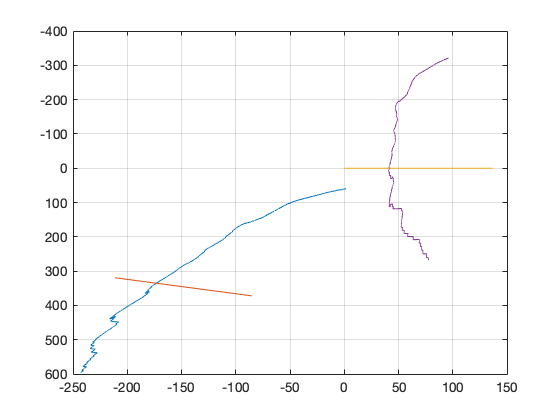

In [21]:
plot(points(:,1),points(:,2))
grid on
axis ij
hold on
plot(transects.x(:,60),transects.y(:,60))
A = [transects.x(:,60) transects.y(:,60)];
A_new = A - repmat([transects.x(1,60) transects.y(1,60)],2,1);
A_rot = A_new*[cos(angle) -sin(angle); sin(angle) cos(angle)];
plot(A_rot(:,1),A_rot(:,2))
plot(points_rot(:,1),points_rot(:,2))

In [ ]:
plot(points(:,1),points(:,2))
axis ij
hold on
plot(transects.x(:,60),transects.y(:,60))
plot(points(905:910,1),points(905:910,2),'rx')
A = [transects.x(:,60) transects.y(:,60)];
>> A_trans = A - repmat([transects.x(1,60) transects.y(1,60)],2,1);
A_rot = A_trans*[cos(angle) -sin(angle); sin(angle) cos(angle)];
plot(A_rot(:,1),A_rot(:,2))
>> plot(points_rot(:,1),points_rot(:,2))
>> plot(points_rot(905:910,1),points_rot(905:910,2),'rx')